In [1]:
import os
import seaborn as sns
path = '/Users/connormcdonald/Desktop/Masters/MIT807/Gartner Repository/Analysis/Figures'
import sys
sys.path.insert(1, '/Users/connormcdonald/Desktop/Masters/MIT807/Gartner Repository/Data Collection')
from configs import *
from scipy import stats
import numpy as np
import statsmodels.formula.api as smf
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# from mpl_toolkits.axisartist.axislines import SubplotZero
# from pylab import text
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "lualatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

from sqlalchemy import create_engine

engine = create_engine('mysql+mysqlconnector://'+user+':'+passwd+'@'+ip+':3306/'+schema1)

In [2]:
df = pd.read_csv('/Users/connormcdonald/Desktop/Masters/MIT807/Data/twitterMAU.csv')
df['period']  = pd.to_datetime(df['period'])

In [3]:
df1 = df.iloc[:38,:]

In [4]:
import matplotlib.dates as mdates


degree = 3
y = np.array(df1['mau'].to_list())
X = np.array(mdates.date2num(df1['period']))
date_index = []
idx = 0
for i in X:
    date_index.append(idx)
    idx += 1

z = np.polyfit(date_index, y, degree)
f = np.poly1d(z)

df_trend = pd.DataFrame(columns=['X', 'y','d'])
df_trend['X'] = date_index
df_trend['y'] = y
df_trend['d'] = X


z = np.polyfit(df_trend.d, df_trend.y, degree)
model = np.poly1d(z)
results = smf.ols(formula='y ~ model(X)', data=df_trend).fit()

# print(results.summary().as_latex())

In [5]:
X = mdates.date2num(df['period'])

In [6]:
x_fit = mdates.date2num(df['period'])
y_fit = [model(_x) for _x in x_fit]

In [7]:
def dformat(d):
    return d.strftime('%Y-%m')

def yformat(d):
    return d.strftime('%Y')

In [8]:
df['y_fit'] = y_fit
df['combined_mau'] = np.where(df["mau"].isnull(), df["y_fit"], df["mau"] )*1000000
df['period_formatted'] = df['period'].apply(dformat)

In [2]:
stmt = '''SELECT 
date, 
retweet_count,
like_count,
reply_count,
quote_count
FROM social.five_g_only'''
df2 = pd.read_sql(stmt, con=engine)


In [3]:
df2.head()

,date,retweet_count,like_count,reply_count,quote_count
0,2010-01-30,0,0,0,0
1,2010-01-30,0,0,0,0
2,2010-01-30,0,0,0,0
3,2010-01-30,0,0,0,0
4,2010-01-30,0,0,0,0


In [54]:
# dfkde = df2[df2.retweet_count >100]

# dfkde = dfkde[dfkde.retweet_count < 50]

In [7]:

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams["figure.figsize"] = [4, 4]
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.dpi'] = 300


sns.histplot(data=df2, x="retweet_count", log_scale=True, binrange = [-1, 100000])
#add axis labels
plt.xlabel('Number of Retweets')
plt.ylabel('Count')
plt.show()
plt.savefig(os.path.join(path, '5g_kde1.pdf'), format='pdf',bbox_inches='tight',pad_inches = 0)
plt.close()

/Users/connormcdonald/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/connormcdonald/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:450: RuntimeWarning: overflow encountered in power
  edges = np.power(10, edges)
/Users/connormcdonald/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1281: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
/Users/connormcdonald/opt/anaconda3/lib/python3.8/site-packages/matplotlib/transforms.py:1977: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[0, 2] += tx


In [55]:

# ax = plt.gca()
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# plt.rcParams["figure.figsize"] = [4, 4]
# plt.rcParams.update({'font.size': 12})
# plt.rcParams['figure.dpi'] = 300

# sns.kdeplot(dfkde.retweet_count, color='#FF9A00',shade=True)

# #add axis labels
# plt.xlabel('Number of Retweets')
# plt.ylabel('Density')
# plt.show()
# plt.savefig(os.path.join(path, '5g_kde2.pdf'), format='pdf',bbox_inches='tight',pad_inches = 0)
# plt.close()

<ipython-input-55-609aae7b01d6>:13: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [28]:
data = pd.read_csv('/Users/connormcdonald/Desktop/processed_ml_V0.csv')

<AxesSubplot:xlabel='Count(1)', ylabel='retweet_count'>

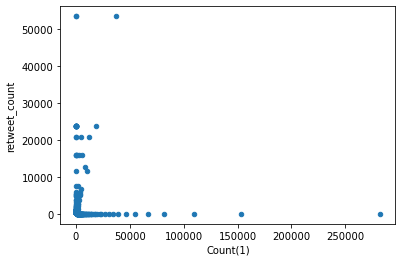

In [29]:
data.plot.scatter(x ="Count(1)", y ="retweet_count")

In [30]:
X = data.iloc[:, [0, 1]].values

In [32]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X) 

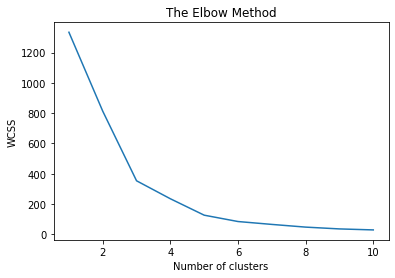

In [33]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [34]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

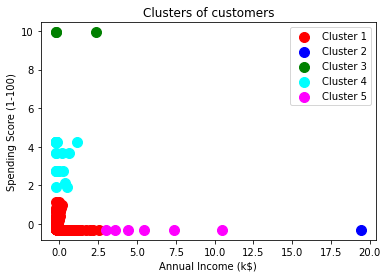

In [36]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5')
plt.title('Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

In [38]:
data = pd.read_csv('/Users/connormcdonald/Desktop/processed_ml_V2.csv')

In [39]:
data.head()

,total_rt
0,1997136736
1,456758754
2,252215379
3,115152470
4,110194610


In [44]:
3613787612/(3613787612+2223377)

0.9993851299106216

In [45]:
(3613787612+2223377)/4840197

747.0793004912816

In [41]:
s = sum(data.total_rt)

In [43]:
c = 0
for i in data.total_rt:
    c += 100*i/s
    print(c)

55.26436388702746
67.90369975954192
74.88295272290063
78.06942858599847
81.11871154978101
84.0227603558457
86.80212967092321
88.02780076052791
88.94843532935326
89.62448640437698
90.21392846038677
90.78442673570157
91.31816745516032
91.80943545168142
92.29593996958998
92.69880675544248
93.05258440849398
93.35379984140582
93.61025957271998
93.83366830247463
94.03257750167967
94.20831799010547
94.35894325048118
94.4798469800056
94.58781707728093
94.6872847933156
94.78455348692471
94.88015761121046
94.97466512982221
95.06454810991805
95.15267362646543
95.23208449141141
95.30728404079765
95.38083235866709
95.44530764748215
95.50974187134932
95.57403485836065
95.63819930987131
95.69897523905726
95.75633688347479
95.81343570115705
95.86751740738434
95.92136119149437
95.97509780273161
96.02557024870335
96.07483404589188
96.12353890043715
96.17042759955089
96.21520986607442
96.25969947566468
96.3029484202017
96.34600305337476
96.38643113484663
96.42471990963254
96.4628800105588
96.498822355252

In [19]:
def rep(str):
    strValue = str[:-3]
    return strValue

In [20]:
df2['date'] = df2['date'].apply(rep)

In [21]:
df2['date'] = pd.to_datetime(df2['date'])
df2 = df2.groupby(df2.date)['retweet_count'].sum()

In [22]:
df2 = pd.DataFrame(df2)

In [23]:
df2.reset_index(inplace=True)
df2 = df2.rename(columns = {'index':'date'})

In [24]:
df2

,date,retweet_count
0,2010-01-01,128
1,2010-02-01,273
2,2010-03-01,253
3,2010-04-01,547
4,2010-05-01,276
...,...,...
105,2018-10-01,21498611
106,2018-11-01,579306948
107,2018-12-01,19633377
108,2019-01-01,159183114


In [25]:
df2["date"] = df2["date"].apply(dformat)

In [26]:
df3 = pd.merge(df, df2, left_on='period_formatted', right_on='date', how='inner')

In [27]:
df3['retweets_p_user'] = df3['retweet_count']/df3['combined_mau']

In [29]:
df3['date'] = pd.to_datetime(df3['date'])
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.dpi'] = 300


#define colors to use in chart
color_map = ['#FF9A00']

#create area chart
plt.stackplot(df3['date'], df3['retweets_p_user'],
              labels=['Retweets'],
              colors=color_map,
              alpha=0.6)

#add legend
plt.legend(loc='upper left')

#add axis labels
plt.xlabel('Time')
plt.ylabel('Monthly Retweets Per Active User')
plt.show()
plt.savefig(os.path.join(path, '5g_normalised_area3.pdf'), format='pdf',bbox_inches='tight',pad_inches = 0)
plt.close()

<ipython-input-29-a067d8718ca9>:25: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()
